# Fine tuning, feature extracting and combination with RandomForest

## Setup

In [1]:
# torch imports
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

# other imports
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import os
from datetime import datetime
import copy

torch.set_printoptions(edgeitems=2)
torch.manual_seed(42)

In [2]:
from google.colab import drive
drive.mount('./gdrive')

Drive already mounted at ./gdrive; to attempt to forcibly remount, call drive.mount("./gdrive", force_remount=True).


In [3]:
# data dir
data_dir = "./gdrive/My Drive/github/data/hymenoptera_data"

# models to choose from: [resnet, alexnet, vgg, densenet]
model_name = "alexnet"

num_classes = 2
batch_size = 32
num_epochs = 100

# Flag for feature extracting. When False, we finetune the whole model,
# when True we only update the reshaped layer params
feature_extract = True

In [4]:
# get device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Device: {device}.")

Device: cuda.


## Helper functions

In [5]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    '''
    trains the model, and returns the model with best accuracy and history 
    for loss and accuracy in both training and validation set
    '''
    
    modelname = model.__class__.__name__
    start = datetime.now()

    loss_history = {'train': [], 'val': []}
    acc_history = {'train': [], 'val': []}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    print(f'Training model {modelname}')
    print(start.strftime("%d/%m/%Y %H:%M:%S"), '\n')
    print('*'*110, '\n')

    for epoch in range(1, num_epochs+1):
        
        epoch_loss_dict = dict()
        epoch_acc_dict = dict()

        # each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()  

            # metrics 
            running_loss = 0.0
            running_corrects = 0

            # iterate over batches
            for inputs, labels in dataloaders[phase]:

                # get data to the right device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track gradient history only if training
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # if training: backward + optimize
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # record epoch loss and accuracy
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            epoch_loss_dict[phase] = epoch_loss
            epoch_acc_dict[phase] = epoch_acc

            loss_history[phase].append(epoch_loss)
            acc_history[phase].append(epoch_acc)

            # check for best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        # end of epoch
        nowtime = datetime.now().strftime("%H:%M:%S")
        if epoch < 4 or epoch % 10 == 0:
            msg_loss = f"train_loss: {epoch_loss_dict['train']:.4f}  valid_loss: {epoch_loss_dict['val']:.4f}"
            msg_acc = f"train_acc: {epoch_acc_dict['train']:.4f}  valid_acc: {epoch_acc_dict['val']:.4f}"
            print(f'epoch {epoch}/{num_epochs}\t{msg_loss}  {msg_acc}   {nowtime}')

    # end of training
    time_elapsed = datetime.now() - start
    time_elapsed_msg = str(time_elapsed).split('.')[0]
    print()
    print('*'*110)
    print(f'\n{modelname} training completed in ', time_elapsed_msg)
    print(f'Best validation Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    log = {'loss': loss_history, 'acc': acc_history}

    return model, log

In [6]:
def set_parameter_requires_grad(model, feature_extract):
    '''
    freezes the pretrained model's layers, to be used before appending
    new or reshaped weights to the net
    '''
    
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False

In [7]:
def get_training_params(model, feature_extracting):
    '''prints and returns training parameters'''
    
    params_to_update = model.parameters()
    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t",name)
    else:
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                print("\t",name)

    return params_to_update

In [8]:
def plot_models(models_dict, phase='val', metric='acc', fig_height = 6):

    '''
    Given a model dictionary with models and logs, plot metric of interest
    on epochs for every model
    '''

    d = pd.DataFrame()
    for k, v in models_dict.items():
        if metric=='acc':
            d[str(k)] = np.stack([h.cpu().numpy() for h in v[1][metric][phase]])
        else:
            d[str(k)] = v[1][metric][phase]

    d['epoch'] = list(range(1, len(d)+1))
    metric_name = 'cross entropy' if metric=='loss' else 'accuracy'
    plotdata = pd.melt(d, id_vars='epoch', value_name=metric_name, var_name='model')
    
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(1.618*fig_height, fig_height))
    sns.lineplot(ax=ax, x='epoch', y=metric_name,
                 hue='model', data=plotdata,
                 palette=sns.color_palette('Dark2')[0:(len(d.columns)-1)])
    ax.set_xlabel('epochs',size=15)
    ax.set_ylabel(metric_name ,size=15)
    ax.set_title('Model comparison',size=18)

In [9]:
models_dict = dict()

## Initialize and reshape newtorks

### Resnet

Uses skip connections to build deep nets, introduced in the paper [Deep Residual Learning for Image Recognition
](https://arxiv.org/abs/1512.03385). A skip connection layer is such that $x_l = H_l(x_{l-1}) + x_{l-1}$, where $H_l$ is the $l$-th layer and $x_{l-1}$ its input. Torchvision has several variants (e.g. Resnet18, Resnet34, Resnet50, Resnet101, Resnet152) with their pretrained weights.
We must reshape the last layer according to our problem.

In [10]:
model = models.resnet18()
#model

In [11]:
# reshape last layer
model.fc = nn.Linear(in_features=512, out_features=num_classes)

### Alexnet

Introduced in the paper [ImageNet Classification with Deep Convolutional
Neural Networks
](https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf), was the first very successful CNN on the ImageNet dataset.

In [12]:
model = models.alexnet()
#model

In [13]:
# reshape last layer
model.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)

### Densenet

Uses Dense blocks of layers, where every layer takes also the input of previous layers. Inside a dense block, we have $x_l = H_l(x_0, x_1, \ldots, x_{l-1})$: ouputs are progressively stacked and sent to subsequent layers. These nets were introduced in [Densely Connected Convolutional Networks
](https://arxiv.org/abs/1608.06993).



In [14]:
model = models.densenet121()
#model

In [15]:
# reshape last layer
model.classifier = nn.Linear(in_features=1024, out_features=num_classes)

### VGG

Introduced in the paper [Very Deep Convolutional Networks for Large-scale Image Recognition
](https://arxiv.org/pdf/1409.1556.pdf). Torchvision offers eight versions of VGG with various lengths and some that have batch normalizations layers. Here we use VGG-11 with batch normalization.

In [16]:
model = models.vgg11_bn()
#model

In [17]:
model.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)

### Initialization function

In [18]:
from torchvision.models.densenet import DenseNet121_Weights
def initialize_model(model_name, num_classes, feature_extract):
    '''
    Initialize and reshape pretrained models, freezing gradients if
    feature extracting is required
    '''
    
    model = None
    input_size = 0

    if model_name == "resnet":
        '''Resnet18'''
        model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        set_parameter_requires_grad(model, feature_extract)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224 # NB could be different for other nets!

    elif model_name == "alexnet":
        '''Alexnet'''
        model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
        set_parameter_requires_grad(model, feature_extract)
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        '''VGG11_bn'''
        model = models.vgg11_bn(weights=models.VGG11_BN_Weights.DEFAULT)
        set_parameter_requires_grad(model, feature_extract)
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "densenet":
        '''Densenet'''
        model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        set_parameter_requires_grad(model, feature_extract)
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    
    else:
        print("Invalid model name, exiting...")
        exit()

    return model, input_size

In [19]:
# example
model_name = 'alexnet'
feature_extract = True

model, input_size = initialize_model(model_name, num_classes, feature_extract)

## Data preparation

In [20]:
# data augmentation and normalization for training
# just normalization for validation

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size), # now we now the input size
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # these are the value used for imagenet, on which the nets were originally trained
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing datasets and dataloaders...")

# create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

# create training and validation dataloaders
data_loaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
    batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}

Initializing datasets and dataloaders...


## Modeling

### Feature Extracting
Freeze every layer but the last one: use pretrained model to extract features and then adapt to current problem with last layer(s). The idea is that general learning that takes place in the early convolution can be transferred. Useful we don't have much data: a model trained from scratch could easily overfit, this way we hve less parameters.

In [21]:
# initialize the model
model_name = 'alexnet'
feature_extract = True
model_name_full = model_name + '_feature_extraction' if feature_extract else model_name + '_fine_tuning'

model, input_size = initialize_model(model_name, num_classes, feature_extract)
model = model.to(device)
params_to_train = get_training_params(model, feature_extract)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [22]:
# optimizer and loss function
optimizer = optim.Adam(params_to_train, lr=0.0005)
criterion = nn.CrossEntropyLoss()

In [23]:
# training
model, log = train_model(model, data_loaders, criterion, optimizer, num_epochs=num_epochs) 

Training model AlexNet
16/10/2022 17:39:00 

************************************************************************************************************************ 

epoch 1/100	train_loss: 0.6195  valid_loss: 0.3551  train_acc: 0.6680  valid_acc: 0.8693   17:39:09
epoch 2/100	train_loss: 0.3443  valid_loss: 0.2782  train_acc: 0.8525  valid_acc: 0.9150   17:39:15
epoch 3/100	train_loss: 0.2791  valid_loss: 0.2406  train_acc: 0.8975  valid_acc: 0.9216   17:39:20
epoch 10/100	train_loss: 0.1695  valid_loss: 0.2436  train_acc: 0.9262  valid_acc: 0.9216   17:39:43
epoch 20/100	train_loss: 0.1342  valid_loss: 0.2616  train_acc: 0.9467  valid_acc: 0.9085   17:40:24
epoch 30/100	train_loss: 0.1043  valid_loss: 0.2666  train_acc: 0.9713  valid_acc: 0.9150   17:41:00
epoch 40/100	train_loss: 0.0951  valid_loss: 0.2752  train_acc: 0.9713  valid_acc: 0.9216   17:41:39
epoch 50/100	train_loss: 0.0655  valid_loss: 0.2820  train_acc: 0.9836  valid_acc: 0.9281   17:42:11
epoch 60/100	train_loss: 0.

In [24]:
# save results
models_dict[model_name_full] = model, log

### Fine tuning
Train all the network, starting from pretrained weights. This might bring better performance if we have enough data, and it's generally better than training from scratch using random weights.

In [25]:
# initialize the model
model_name = 'alexnet'
feature_extract = False
model_name_full = model_name + '_feature_extraction' if feature_extract else model_name + '_fine_tuning'

model, input_size = initialize_model(model_name, num_classes, feature_extract)
model = model.to(device)
params_to_train = get_training_params(model, feature_extract)

Params to learn:
	 features.0.weight
	 features.0.bias
	 features.3.weight
	 features.3.bias
	 features.6.weight
	 features.6.bias
	 features.8.weight
	 features.8.bias
	 features.10.weight
	 features.10.bias
	 classifier.1.weight
	 classifier.1.bias
	 classifier.4.weight
	 classifier.4.bias
	 classifier.6.weight
	 classifier.6.bias


In [26]:
# optimizer and loss function
optimizer = optim.Adam(params_to_train, lr=0.0005)
criterion = nn.CrossEntropyLoss()

In [27]:
# training
model, log = train_model(model, data_loaders, criterion, optimizer, num_epochs=num_epochs) 

Training model AlexNet
16/10/2022 17:44:59 

************************************************************************************************************************ 

epoch 1/100	train_loss: 0.9743  valid_loss: 0.5769  train_acc: 0.6270  valid_acc: 0.7320   17:45:02
epoch 2/100	train_loss: 0.5785  valid_loss: 0.5319  train_acc: 0.7131  valid_acc: 0.7451   17:45:06
epoch 3/100	train_loss: 0.5640  valid_loss: 0.4681  train_acc: 0.7049  valid_acc: 0.7843   17:45:10
epoch 10/100	train_loss: 0.4851  valid_loss: 0.4988  train_acc: 0.8115  valid_acc: 0.7255   17:45:36
epoch 20/100	train_loss: 0.3273  valid_loss: 0.7103  train_acc: 0.8770  valid_acc: 0.8105   17:46:12
epoch 30/100	train_loss: 0.2049  valid_loss: 0.5792  train_acc: 0.9180  valid_acc: 0.7974   17:46:50
epoch 40/100	train_loss: 0.2915  valid_loss: 0.6577  train_acc: 0.8811  valid_acc: 0.7582   17:47:26
epoch 50/100	train_loss: 0.4804  valid_loss: 0.5321  train_acc: 0.7705  valid_acc: 0.7320   17:48:02
epoch 60/100	train_loss: 0.

In [28]:
# save results
models_dict[model_name_full] = model, log

### Plot history

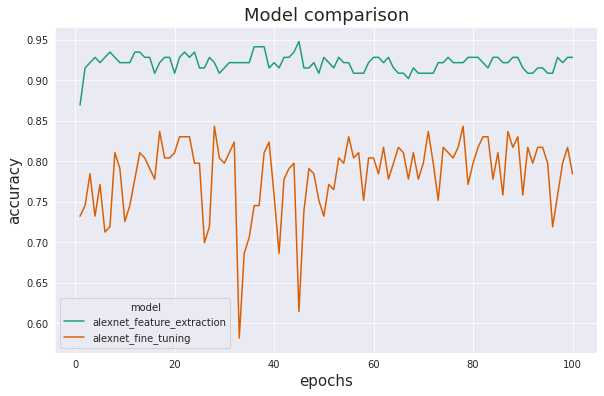

In [29]:
plot_models(models_dict)

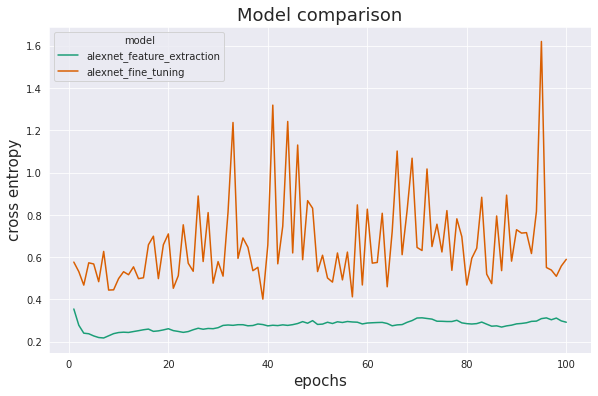

In [30]:
plot_models(models_dict, metric = 'loss')

### Feature extracting + Random Forest
Idea: 
* use pretrained model without reshaping for extracting features;
* reduce dimensionality with PCA;
* classify with random forest.



In [31]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [32]:
# create 1000 features for random forest using resnet
model_ft = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model_ft.to(device)
model_ft.eval()

new_features = {'train':[], 'val':[]}
response = {'train':[], 'val':[]}

for phase in ['train', 'val']:
    # iterate over batches
    for inputs, labels in data_loaders['train']:

        # get data to the right device
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model_ft(inputs)
        new_features[phase].append(outputs)
        response[phase].append(labels)
    
    new_features[phase] = torch.cat(new_features[phase], dim=0)
    response[phase] = torch.cat(response[phase], dim=0)

In [33]:
# prepare tabular data
newx = pd.DataFrame(new_features['train'].cpu().detach().numpy())
newx_val = pd.DataFrame(new_features['val'].cpu().detach().numpy())

y = response['train'].cpu().detach().numpy()
y_val = response['val'].cpu().detach().numpy()

In [34]:
# define pipeline and parameters
pca = PCA(n_components = 20, random_state=42)
rf = RandomForestClassifier(n_estimators=200, random_state=42)
pipe = Pipeline(steps=[('pca', pca), ('randomforest', rf)])

params_grid = {
    'pca__n_components': [20, 50, 100, 150],
    'randomforest__max_features': [0.2, 0.4, 0.8]
}

search = GridSearchCV(pipe, params_grid, scoring='accuracy', verbose=2, n_jobs=2)

In [35]:
search.fit(newx, y)
print(f"best parameters (CV score={search.best_score_:0.3f}): \n\t", search.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
best parameters (CV score=0.910): 
	 {'pca__n_components': 20, 'randomforest__max_features': 0.2}


In [36]:
from sklearn.metrics import accuracy_score

pred = search.best_estimator_.predict(newx_val)
score = accuracy_score(pred, y_val)
print(f'Model: [ResNet18 (feature extractor), PCA, Random Forest]\n\taccuracy: {score:0.4f}')

Model: [ResNet18 (feature extractor), PCA, Random Forest]
	accuracy: 0.9303
